# <b> <font color='blue'> <center> Training Visualization </center> </font> </b>

## Setup

In [1]:
import json
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict
import pandas as pd
from IPython.display import display
from datetime import datetime

## Helper Functions

In [2]:
# loads data for a specific model-data_variant
def load_data(index_path):
    # Load runs_index.json
    with open(index_path) as f:
        runs_index = json.load(f)
    
    # Sort by timestamp
    runs_index.sort(key=lambda x: x["timestamp"])
    
    # Base directory for JSON files
    base_dir = index_path.parent
    
    # Collect runs (no need to group by model_name)
    runs = []
    for run in runs_index:
        run_path = base_dir / run["json_file"]
        with open(run_path) as f:
            run_data = json.load(f)
        runs.append(run_data)

    return runs


In [3]:
# get basic info
def get_data(data):
    # Separate sections
    basic_info_keys = ['model_name', 'data_variant', 'timestamp']
    basic_info = {k: data[k] for k in basic_info_keys}
    hyperparams = data['hyperparameters']
    val_metrics = data.get('val_metrics', {})  # use .get in case it's missing
    
    # Convert to DataFrames
    df_basic = pd.DataFrame([basic_info])
    df_basic["timestamp_readable"] = df_basic["timestamp"].apply(
        lambda x: datetime.strptime(x, "%Y%m%d_%H%M%S").strftime("%Y-%m-%d %H:%M:%S")
    )
    
    df_hyper = pd.DataFrame([hyperparams])
    df_val = pd.DataFrame([val_metrics]) if val_metrics else pd.DataFrame()
    
    # Display nicely in notebook
    print("=== Basic Info ===")
    display(df_basic)
    
    print("=== Hyperparameters===")
    df_hyper_vertical = pd.DataFrame(list(hyperparams.items()), columns=['Parameter', 'Value'])
    display(df_hyper_vertical)
    

    print("=== Validation Metrics===")
    df_val_vertical = pd.DataFrame(list(val_metrics.items()), columns=['Metric', 'Value'])
    display(df_val_vertical)


In [4]:
# plots
def plot_history(history):
    # Plot
    plt.figure(figsize=(12, 5))
    
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='train_loss')#, marker='o')
    plt.plot(history['val_loss'], label='val_loss')#, marker='o')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='train_acc')#, marker='o')
    plt.plot(history['val_accuracy'], label='val_acc')#, marker='o')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()


## Models

### Baseline

#### Simple data

=== Basic Info ===


,model_name,data_variant,timestamp,timestamp_readable
0,baseline,simple,20250901_205927,2025-09-01 20:59:27


=== Hyperparameters===


,Parameter,Value
0,batch_size,32
1,optimizer,adam
2,learning_rate,0.001
3,epochs,20


=== Validation Metrics===


,Metric,Value
0,loss,0.426472
1,accuracy,0.842105
2,precision,0.800000
3,recall,0.761905
4,f1,0.780488


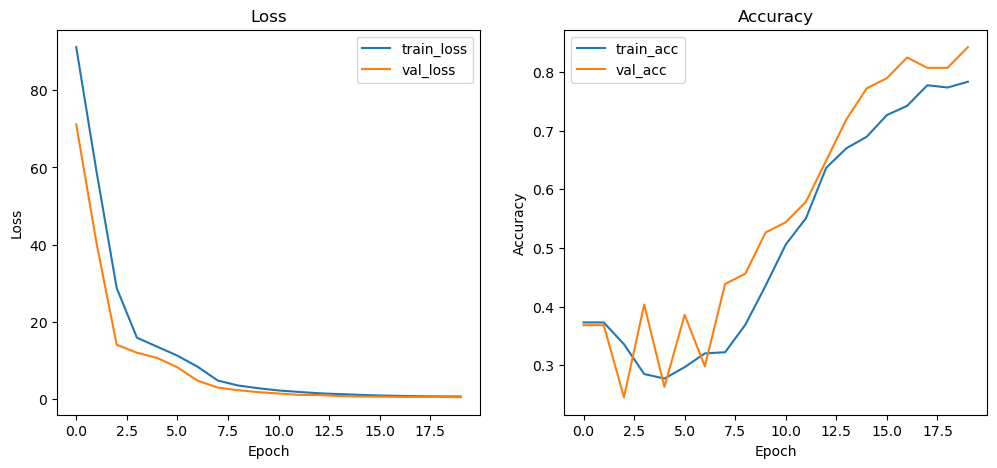

In [5]:
index_path = Path("../logs/training/baseline/simple/runs_index.json")
baseline_models = load_data(index_path)

for b in baseline_models:
    get_data(b)
    history = b['history']
    plot_history(history)

#### Standardize data

=== Basic Info ===


,model_name,data_variant,timestamp,timestamp_readable
0,baseline,standardize,20250901_205934,2025-09-01 20:59:34


=== Hyperparameters===


,Parameter,Value
0,batch_size,32
1,optimizer,adam
2,learning_rate,0.001
3,epochs,20


=== Validation Metrics===


,Metric,Value
0,loss,0.105286
1,accuracy,0.982456
2,precision,0.000000
3,recall,0.000000
4,f1,0.000000


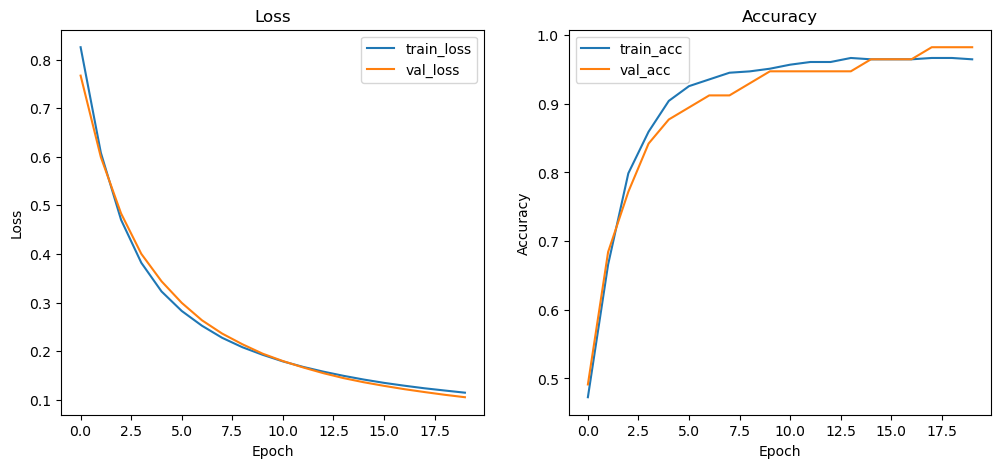

In [6]:
index_path = Path("../logs/training/baseline/standardize/runs_index.json")
baseline_models = load_data(index_path)

get_data(baseline_models[0])

history = baseline_models[0]['history']
plot_history(history)

=== Basic Info ===


,model_name,data_variant,timestamp,timestamp_readable
0,dropout,simple,20250901_205931,2025-09-01 20:59:31


=== Hyperparameters===


,Parameter,Value
0,batch_size,32
1,dropout_rate,0.1
2,optimizer,adam
3,learning_rate,0.001
4,epochs,20


=== Validation Metrics===


,Metric,Value
0,loss,0.315195
1,accuracy,0.894737
2,precision,0.000000
3,recall,0.000000
4,f1,0.000000


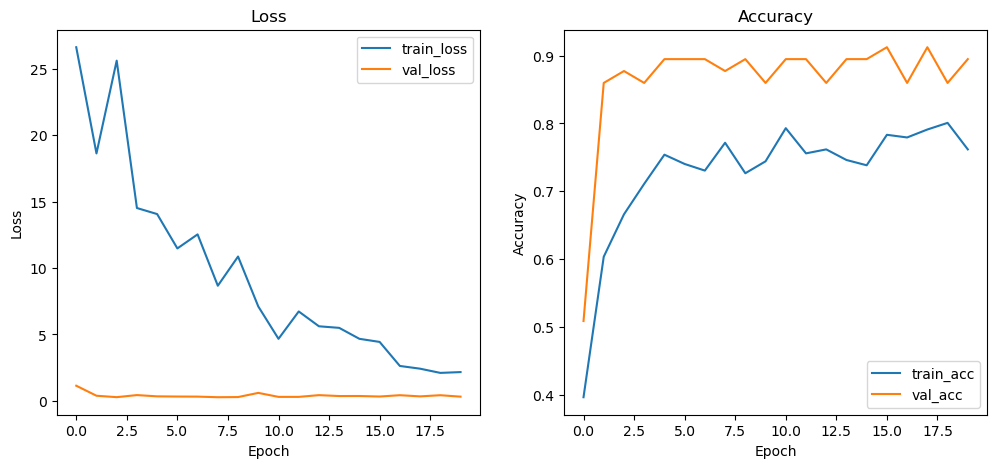

In [7]:
index_path = Path("../logs/training/dropout/simple/runs_index.json")
baseline_models = load_data(index_path)

for b in baseline_models:
    get_data(b)
    history = b['history']
    plot_history(history)

=== Basic Info ===


,model_name,data_variant,timestamp,timestamp_readable
0,dropout,standardize,20250901_205938,2025-09-01 20:59:38


=== Hyperparameters===


,Parameter,Value
0,batch_size,32
1,dropout_rate,0.1
2,optimizer,adam
3,learning_rate,0.001
4,epochs,20


=== Validation Metrics===


,Metric,Value
0,loss,0.037539
1,accuracy,1.000000
2,precision,0.000000
3,recall,0.000000
4,f1,0.000000


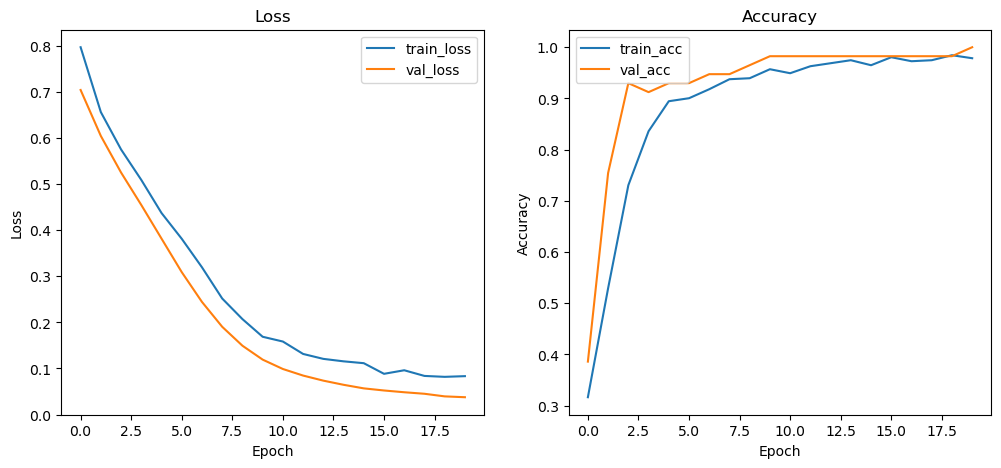

In [8]:
index_path = Path("../logs/training/dropout/standardize/runs_index.json")
baseline_models = load_data(index_path)

for b in baseline_models:
    get_data(b)
    history = b['history']
    plot_history(history)

=== Basic Info ===


,model_name,data_variant,timestamp,timestamp_readable
0,no_dropout,simple,20250901_205929,2025-09-01 20:59:29


=== Hyperparameters===


,Parameter,Value
0,batch_size,32
1,optimizer,adam
2,learning_rate,0.001
3,epochs,20


=== Validation Metrics===


,Metric,Value
0,loss,0.666067
1,accuracy,0.736842
2,precision,0.625000
3,recall,0.714286
4,f1,0.666667


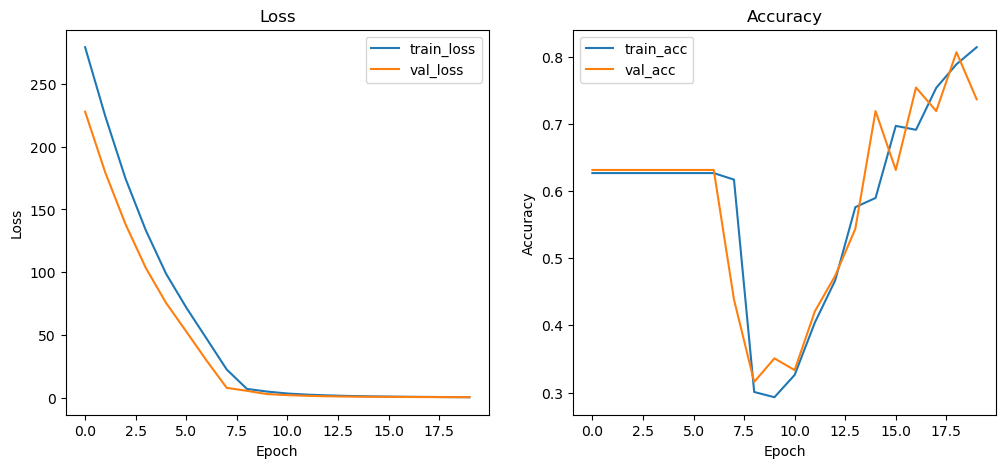

In [9]:
index_path = Path("../logs/training/no_dropout/simple/runs_index.json")
baseline_models = load_data(index_path)

for b in baseline_models:
    get_data(b)
    history = b['history']
    plot_history(history)

=== Basic Info ===


,model_name,data_variant,timestamp,timestamp_readable
0,no_dropout,standardize,20250901_205936,2025-09-01 20:59:36


=== Hyperparameters===


,Parameter,Value
0,batch_size,32
1,optimizer,adam
2,learning_rate,0.001
3,epochs,20


=== Validation Metrics===


,Metric,Value
0,loss,0.075296
1,accuracy,1.000000
2,precision,0.000000
3,recall,0.000000
4,f1,0.000000


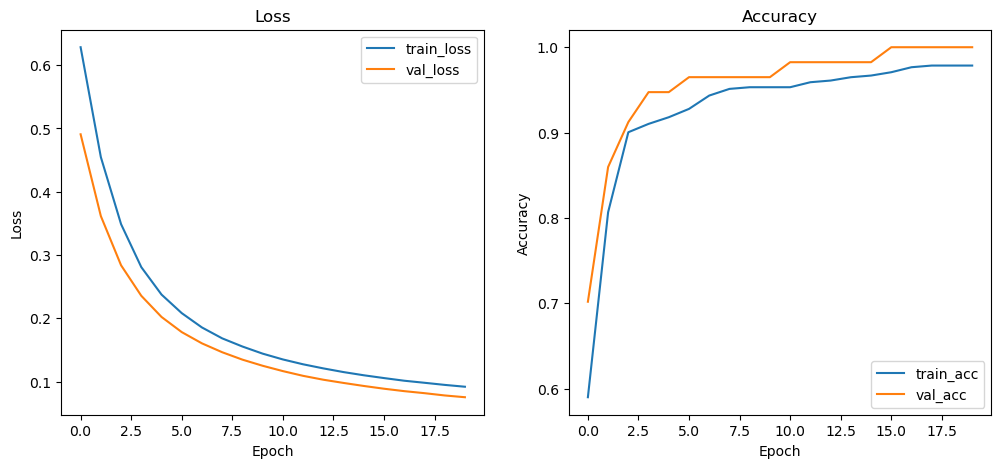

In [10]:
index_path = Path("../logs/training/no_dropout/standardize/runs_index.json")
baseline_models = load_data(index_path)

for b in baseline_models:
    get_data(b)
    history = b['history']
    plot_history(history)

Analysis:
    
    
- We always obatin much better results and a more stable training with standardize data.

- We reach very good results even training our models for a very few epochs; but thats because our probelm is very simple.